In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import time as tm
import Sprayer_PDE as SP

import pypolo2

# Environment -- PINNS

In [2]:
Setting = pypolo2.utilities.Config()

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model
Setting.env = env_model.solve(Setting.delta_t)


100%|██████████| 3.0/3.0 [00:01<00:00,  1.78it/s]    


In [3]:
# 确定存放地址
starttime = Setting.starttime.replace(' ', '-').replace(':', '-')
Savedir = '{}/{}/releaserate_{}'.format(Setting.root_dir,Setting.strategy_name,"%03d" %(Setting.delta_t*100))
Savename = 'seed{}'.format(Setting.seed)
Setting.save_dir = Savedir
Setting.save_name = Savename
evaluator = pypolo2.experiments.Evaluator()
logger = pypolo2.experiments.Logger(None, Setting)

# Sensor

In [4]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [5]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 11 in random, numpy, and torch.


# Set initual data

In [6]:
# 初始化污染源
if Setting.randomsource == True:
    # gengerate two set of random numbers for source locations
    numbers = rng.randint(0, 19, size=Setting.sourcenum * 2)
    pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
    for i in range(Setting.sourcenum):
        number = rng.randint(120, 260, size=1)
        Setting.RR[i,0] = int(pairs[i,0])
        Setting.RR[i,1] = int(pairs[i,1])
        Setting.RR[i,2] = number

# print(Setting.RR)
# # #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
s = 1
Setting.R =  -6.6 * np.ones((Setting.grid_x, Setting.grid_y)) + 12 * np.random.random((Setting.grid_x, Setting.grid_y))
for i in range(Setting.sourcenum):
        Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
        

env_model = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = 0) # build model

y_init = np.zeros((Setting.num_init_samples,1))
y_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))
time_init = np.zeros((Setting.num_init_samples,1))
time_stations = np.zeros((Setting.station_size*Setting.time_before_sche,1))

#固定站的观测的观测
for time in range(Setting.time_before_sche):
    # y_stations[Setting.station_size*time:Setting.station_size*(time+1)] = sensor.sense(states=Setting.x_station, rng=rng).reshape(-1, 1)
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*Setting.time_co
    time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-Setting.time_before_sche+1)*1
    # time_stations[Setting.station_size*time:Setting.station_size*(time+1)] = (time-10+1)*Setting.time_co
    Setting.env = env_model.solve((time+1)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
#假设每次观测后均变化时间，环境也随之发生变化
for time in range(Setting.num_init_samples):
    y_init[time] = sensor.sense(states=Setting.x_init[time], rng=rng).reshape(-1, 1)
    if time == 0:
        y_stations[:] = y_init[time] - 20
    # time_init[time] = (time+1)*Setting.time_co
    time_init[time] = (time+1)*1
    Setting.env = env_model.solve((1+Setting.time_before_sche+time)*Setting.delta_t)
    sensor.set_env(Setting.env)
    
Setting.x_init = np.hstack((Setting.x_init,time_init))

Setting.x_stations = Setting.x_station
for i in range(Setting.time_before_sche-1):
    Setting.x_stations = np.vstack((Setting.x_stations,Setting.x_station))
Setting.x_stations = np.hstack((Setting.x_stations,time_stations))

Setting.x_init = np.vstack((Setting.x_stations,Setting.x_init))
y_init = np.vstack((y_stations,y_init))

100%|██████████| 3.0/3.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 6.0/6.0 [00:00<00:00, 10.94it/s]    
100%|██████████| 9.0/9.0 [00:00<00:00, 10.63it/s]    
100%|██████████| 12.0/12.0 [00:01<00:00,  9.53it/s]   
100%|██████████| 15.0/15.0 [00:01<00:00, 12.17it/s]   
100%|██████████| 18.0/18.0 [00:01<00:00, 12.24it/s]   


# Model

In [7]:
Setting.time_stamp = Setting.x_init[:,2].max(axis=0, keepdims=False)

In [8]:
kernel = pypolo2.kernels.RBF(Setting)

In [9]:
model = pypolo2.models.GPR(
    x_train=Setting.x_init,
    y_train=y_init,
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [10]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 05 loss:  8.64: 100%|██████████| 6/6 [00:00<00:00, 50.67it/s]


# Robot

In [11]:
vehicle_team = dict()
for i in range(Setting.team_size):
    robot = pypolo2.robots.SPRINKLER_REPLENISHANYWHERE(
        init_state = np.array([Setting.x_init[-1, 0], Setting.x_init[-1, 1]]),
        Setting = Setting
    )
    vehicle_team[i+1] = robot #因此team的id从1开始

# Strategy

In [12]:
strategy = pypolo2.strategies.SAEffectOrientedGreedySpray(
            task_extent=Setting.task_extent,
            rng=rng,
            vehicle_team=vehicle_team,
        )
Setting.strategy = strategy

# Experiment

In [13]:
#定义需要随时间更新的训练过程
def run(rng, model, Setting, sensor, evaluator, logger, vehicle_team) -> None:
    current_step = 0 #总规划长度
    adaptive_step = Setting.adaptive_step #自适应长度
    # change_step = Setting.R_change_interval - 0*Setting.adaptive_step # 污染源变化间隔
    change_step = 0
    spray_effect = 0 # 洒水效果
    result, MI_information, observed_env, computed_effect = None, None, None, None
    init_env = Setting.env
    tstart = 0
    while current_step < Setting.max_num_samples:
        # 计算用于洒水效果,环境真实值已知
        allpoint_list = []
        env_list = []
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                allpoint_list.append([i, j, model.time_stamp])
                env_list.append(Setting.env[i,j])
        allpoint = np.array(allpoint_list)
        env = np.array(env_list)
        mean, _ = model(allpoint)
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, mean, Setting.task_extent).ravel()
        prior_diag_std, poste_diag_std, _, _ = model.prior_poste(allpoint)
        hprior = pypolo2.objectives.entropy.gaussian_entropy(prior_diag_std.ravel())
        hposterior = pypolo2.objectives.entropy.gaussian_entropy(poste_diag_std.ravel())
        mi_all = hprior - hposterior
        if np.any(mi_all < 0.0):
            print(mi_all.ravel())
            raise ValueError("Predictive MI < 0.0!")
        
        sprayeffect_all = pypolo2.objectives.sprayeffect.spray_effect(allpoint, allpoint, env, Setting.task_extent).ravel()
        MI_information = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        observed_env = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        computed_effect = np.zeros((Setting.task_extent[1]-Setting.task_extent[0],Setting.task_extent[3]-Setting.task_extent[2]))
        for i in range (Setting.task_extent[0],Setting.task_extent[1]):
            for j in range (Setting.task_extent[2],Setting.task_extent[3]):
                MI_information[i,j] = mi_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                observed_env[i,j] = Setting.env[i,j]
                computed_effect[i,j] = sprayeffect_all[i*(Setting.task_extent[3]-Setting.task_extent[2])+j]
                
        Setting.current_step = current_step
        # scheduling and update agent goals 计算搜索时间
        if adaptive_step >= Setting.adaptive_step:
            start = tm.time()
            result = Setting.strategy.get(model = model, Setting = Setting, pred = observed_env)
            adaptive_step = 0
            for id, vehicle in vehicle_team.items():
                vehicle.set_goals(result[id][0],result[id][1])
            end = tm.time()
            print('search_time')
            print(end-start)    
            
        # calculate metrix and save 
        coverage, mean_airpollution, max_airpollution = evaluator.eval_results(Setting.env, Setting.task_extent, vehicle_team)
        logger.append(current_step, Setting.env, observed_env, MI_information, computed_effect, vehicle_team, coverage, mean_airpollution, max_airpollution, spray_effect)
           
        # change source,每经过R_change_interval后，改变源分布和强度，
        if change_step >= Setting.R_change_interval:
            Setting.R =  -6.5 * np.ones((Setting.grid_x, Setting.grid_y)) + 12 * np.random.random((Setting.grid_x, Setting.grid_y))
            change_step = 0
            if Setting.randomsource == True:
                # gengerate two set of random numbers for source locations
                numbers = rng.randint(0, 4, size=Setting.sourcenum * 2)
                pairs = rng.choice(numbers, size=(Setting.sourcenum, 2), replace=False)
                for i in range(Setting.sourcenum):
                    # number = rng.randint(120, 260, size=1)
                    number = 200
                    # Setting.RR[i,0] = int(pairs[i,0])
                    # Setting.RR[i,1] = int(pairs[i,1])
                    if Setting.RR[i,0]+pairs[i,0]-2 < Setting.grid_x-1 and Setting.RR[i,0] + pairs[i,0] - 2 >=0:
                        Setting.RR[i,0] = int(Setting.RR[i,0]+pairs[i,0]-2)
                    if Setting.RR[i,1]+pairs[i,1]-2 < Setting.grid_y-1 and Setting.RR[i,1] + pairs[i,1] - 2 >=0:
                        Setting.RR[i,1] = int(Setting.RR[i,1]+pairs[i,1]-2)
                    Setting.RR[i,2] = number
                init_env = Setting.env
                tstart = current_step

        # print(Setting.RR)
        # #  每周期更新源信息,源是缓慢变化的，源会不断变强到顶峰，然后变弱。定义一个强度系数
        s = 1
        for i in range(Setting.sourcenum):
             Setting.R[Setting.RR[i,0],Setting.RR[i,1]] = s*Setting.RR[i,2]
                
        # 计算如果没有更新洒水时的环境变化
        env_model1 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field = Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t) # build model
        env_withoutspray = env_model1.solve(Setting.delta_t)
        # update state 并将车辆的轨迹和洒水轨迹取出来
        x_new = []
        y_new = []
        for id, vehicle in vehicle_team.items():
            vehicle.update()
            current_state = vehicle.state.copy().reshape(1, -1)
            x_new.append(current_state)
            y_new.append(sensor.sense(current_state, rng).reshape(-1, 1))
            if Setting.current_step == 0:
                Setting.data_sprayer_train.append(pd.DataFrame())
            else:
                if vehicle.spray_flag == True:
                    new_pd = pd.DataFrame({"time":(Setting.current_step + 1) * Setting.delta_t, "x":current_state[0,0],\
                                            "y":current_state[0,1], "spray_volume":4000},index=[0])
                    # Setting.data_sprayer_train[id-1] = Setting.data_sprayer_train[id-1].append(new_pd, ignore_index=True)
                    Setting.data_sprayer_train[id-1] = pd.concat([Setting.data_sprayer_train[id-1],new_pd])
        # 计算带入洒水后的环境情况
        env_model2 = SP.Diffusion_Model(x_range = Setting.grid_x, y_range = Setting.grid_y,\
                 initial_field =  Setting.env, R_field =  Setting.R, data_sprayer_train = Setting.data_sprayer_train, t_start = current_step * Setting.delta_t) # build model
        Setting.env = env_model2.solve(Setting.delta_t)
        sensor.set_env(Setting.env)
        # 计算洒水效果
        spray_effect = np.sum(env_withoutspray - Setting.env)
        print(spray_effect)
            
        # using new data to update gpr model
        x_new = np.concatenate(x_new, axis=0)
        y_new = np.concatenate(y_new, axis=0)
        #add time dim
        model.time_stamp = model.time_stamp + Setting.time_co
        Setting.time_stamp = model.time_stamp
        model_input = np.zeros((x_new.shape[0],3))
        model_input[:,0:2] = x_new
        model_input[:,2:3] = model.time_stamp
        #optimize model
        model.add_data(model_input, y_new)
        model.optimize(num_iter=len(y_new), verbose=False)
        
        adaptive_step = adaptive_step + 1    
        current_step = current_step + 1
        change_step = change_step + 1  
    return 0

In [14]:
start = tm.time()
Setting.strategy = strategy
run(rng, model, Setting, sensor, evaluator, logger, vehicle_team)
# pypolo2.experiments.utilities.print_metrics(logger, Setting.max_num_samples-1)
end = tm.time()
# logger.save(end-start)  # I temporarily removed "makefile()".

current_turn
1.0
agent_number
5
single_playout
135
search_time
6.962587118148804


100%|██████████| 3.0/3.0 [00:00<00:00,  4.91it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  5.15it/s]    


-3.3537027205755967


100%|██████████| 3.0/3.0 [00:00<00:00,  4.14it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.26it/s]    


-3.189942416743741


100%|██████████| 3.0/3.0 [00:00<00:00,  4.47it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.34it/s]    


1911.4621473776012


100%|██████████| 3.0/3.0 [00:00<00:00,  4.02it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.13it/s]    


1214.033518552254


100%|██████████| 3.0/3.0 [00:00<00:00,  4.00it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.43it/s]    


1196.7208783530302


100%|██████████| 3.0/3.0 [00:00<00:00,  3.72it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.80it/s]    


1437.4009088628356


100%|██████████| 3.0/3.0 [00:00<00:00,  4.07it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.45it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.72it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.05it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.60it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.11it/s]    


2.9501767624335526
current_turn
2.0
single_playout
135
search_time
6.944810628890991


100%|██████████| 3.0/3.0 [00:00<00:00,  4.69it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.80it/s]    


2944.8189713779884


100%|██████████| 3.0/3.0 [00:00<00:00,  3.88it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.47it/s]    


1285.4533577398022


100%|██████████| 3.0/3.0 [00:00<00:00,  3.96it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.68it/s]    


1073.3251446336308


100%|██████████| 3.0/3.0 [00:00<00:00,  3.28it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.72it/s]    


1037.6029745151777


100%|██████████| 3.0/3.0 [00:00<00:00,  3.55it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.80it/s]    


1027.6177799344907


100%|██████████| 3.0/3.0 [00:00<00:00,  4.45it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.91it/s]    


1180.140800390707


100%|██████████| 3.0/3.0 [00:00<00:00,  4.28it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.90it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.09it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.37it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  4.18it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  5.08it/s]    


2.4393307116393963
current_turn
3.0
single_playout
135
search_time
6.779068470001221


100%|██████████| 3.0/3.0 [00:01<00:00,  2.11it/s]    
100%|██████████| 3.0/3.0 [00:01<00:00,  2.19it/s]    


2570.108634453204


100%|██████████| 3.0/3.0 [00:01<00:00,  2.57it/s]    
100%|██████████| 3.0/3.0 [00:01<00:00,  2.81it/s]    


1733.7009968510392


100%|██████████| 3.0/3.0 [00:00<00:00,  3.43it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.39it/s]    


1799.7749428293062


100%|██████████| 3.0/3.0 [00:00<00:00,  3.13it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.45it/s]    


1182.1905497490854


100%|██████████| 3.0/3.0 [00:00<00:00,  3.05it/s]    
100%|██████████| 3.0/3.0 [00:01<00:00,  2.90it/s]    


995.4940164082775


100%|██████████| 3.0/3.0 [00:00<00:00,  3.36it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.61it/s]    


890.334515257186


100%|██████████| 3.0/3.0 [00:00<00:00,  3.33it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.40it/s]    


0.0


100%|██████████| 3.0/3.0 [00:01<00:00,  2.91it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.04it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.99it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.68it/s]    


0.0
current_turn
4.0
single_playout
135
search_time
7.291489601135254


100%|██████████| 3.0/3.0 [00:00<00:00,  4.48it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.10it/s]    


2262.032187339083


100%|██████████| 3.0/3.0 [00:00<00:00,  4.08it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.18it/s]    


1749.9917198411472


100%|██████████| 3.0/3.0 [00:00<00:00,  3.10it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.12it/s]    


1728.690270303359


100%|██████████| 3.0/3.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.85it/s]    


1235.1042655915785


100%|██████████| 3.0/3.0 [00:00<00:00,  3.92it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.80it/s]    


948.9859605450414


100%|██████████| 3.0/3.0 [00:00<00:00,  3.80it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.04it/s]    


965.489672414259


100%|██████████| 3.0/3.0 [00:00<00:00,  3.36it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.38it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  4.07it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.52it/s]    


-1.8045415954427733


100%|██████████| 3.0/3.0 [00:00<00:00,  3.63it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.99it/s]    


0.0
current_turn
5.0
single_playout
135
search_time
7.314906597137451


100%|██████████| 3.0/3.0 [00:00<00:00,  3.63it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.06it/s]    


2527.5453398655436


100%|██████████| 3.0/3.0 [00:00<00:00,  3.94it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.18it/s]    


1025.9250678044332


100%|██████████| 3.0/3.0 [00:00<00:00,  3.87it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.66it/s]    


884.6927192580348


100%|██████████| 3.0/3.0 [00:00<00:00,  3.84it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.22it/s]    


898.3553150078782


100%|██████████| 3.0/3.0 [00:00<00:00,  3.66it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.12it/s]    


1010.6992215076128


100%|██████████| 3.0/3.0 [00:00<00:00,  3.94it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.82it/s]    


1204.413033281599


100%|██████████| 3.0/3.0 [00:00<00:00,  3.78it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.23it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.29it/s]    
100%|██████████| 3.0/3.0 [00:01<00:00,  2.59it/s]    


0.0


100%|██████████| 3.0/3.0 [00:00<00:00,  3.65it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.12it/s]    


0.0
current_turn
6.0
single_playout
135
search_time
6.954481363296509


100%|██████████| 3.0/3.0 [00:00<00:00,  4.21it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  3.88it/s]    


1933.1490035709253


100%|██████████| 3.0/3.0 [00:01<00:00,  2.88it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.11it/s]    


1750.1222739897855


100%|██████████| 3.0/3.0 [00:00<00:00,  3.80it/s]    
100%|██████████| 3.0/3.0 [00:00<00:00,  4.35it/s]    

1691.5545589000362


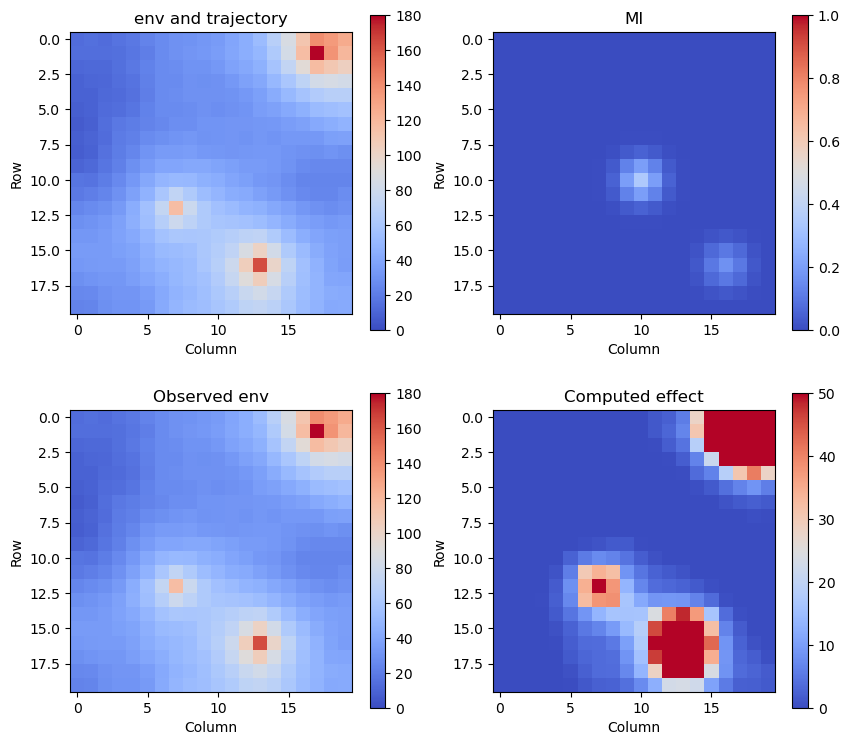

In [15]:
from pypolo2.experiments import visualizer
ani = visualizer.visual(logger)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

In [16]:
import math
import numpy as np
Temp = 2500
k = math.pow(0.00002, 1 / 10)
k = math.pow(k, 7)
delta_e_2 = -10
accept_prob = np.exp(delta_e_2 / (k * Temp))
print(k)
print(accept_prob)

0.0005137135214831111
0.00041532843149921


In [17]:
numbers = rng.randint(0, 19, size=10)
pairs = rng.choice(numbers, size=(5, 2), replace=False)
print(pairs)

[[11  8]
 [ 3  5]
 [ 5 14]
 [17  2]
 [14 18]]


In [18]:
Setting.RR

array([[  5,  10, 200],
       [  0,  14, 200],
       [ 13,  11, 200]])